In [19]:
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [20]:
df=pd.read_csv("dataset_57_hypothyroid.csv", parse_dates=True, encoding='UTF-8',
               true_values=['t'], false_values=['f'], na_values=['?'])


In [21]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41.0,F,False,False,False,False,False,False,False,False,...,True,125.0,True,1.14,True,109.0,False,NaN,SVHC,negative
1,23.0,F,False,False,False,False,False,False,False,False,...,True,102.0,False,NaN,False,NaN,False,NaN,other,negative
2,46.0,M,False,False,False,False,False,False,False,False,...,True,109.0,True,0.91,True,120.0,False,NaN,other,negative
3,70.0,F,True,False,False,False,False,False,False,False,...,True,175.0,False,NaN,False,NaN,False,NaN,other,negative
4,70.0,F,False,False,False,False,False,False,False,False,...,True,61.0,True,0.87,True,70.0,False,NaN,SVI,negative


In [22]:
df.replace("F", 0, inplace=True)
df.replace("M", 1, inplace=True)
# df.replace("negative", 1, inplace=True)
df.replace("M", 1, inplace=True)

In [23]:
pandas_profiling.ProfileReport(df)


Number of variables,30
Number of observations,3772
Total Missing (%),5.4%
Total size in memory,368.4 KiB
Average record size in memory,100.0 B
Numeric,7
Categorical,2
Boolean,18
Date,0
Text (Unique),0
Rejected,3


In [24]:
df.shape

(3772, 30)

Заполним пропуски в данных:

In [25]:
total = df.isnull().sum().sort_values(ascending=False)
total

TBG                          3772
T3                            769
T4U                           387
FTI                           385
TSH                           369
TT4                           231
sex                           150
age                             1
query_hypothyroid               0
I131_treatment                  0
thyroid_surgery                 0
pregnant                        0
on_antithyroid_medication       0
sick                            0
lithium                         0
query_on_thyroxine              0
on_thyroxine                    0
query_hyperthyroid              0
Class                           0
goitre                          0
tumor                           0
referral_source                 0
psych                           0
TSH_measured                    0
T3_measured                     0
TT4_measured                    0
T4U_measured                    0
FTI_measured                    0
TBG_measured                    0
hypopituitary 

В колонке TBG данных совсем нет, удаляем.

In [26]:
df.drop(columns=['TBG'], inplace=True)

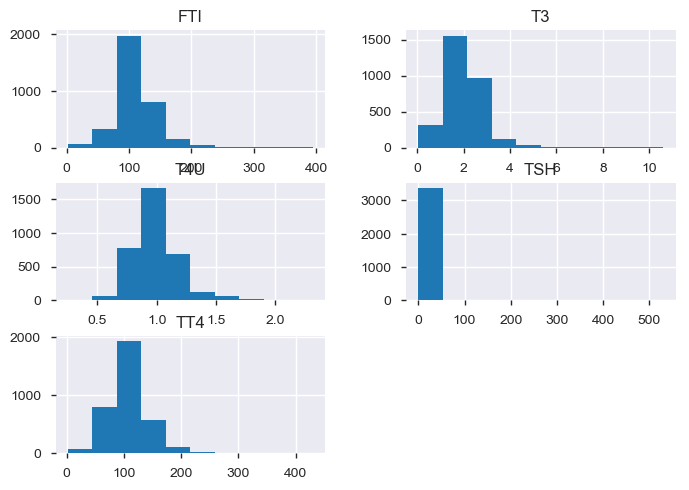

In [27]:
_ = df[['T3', 'T4U', 'FTI', 'TSH', 'TT4']].hist()

заполняем средними значениями

In [28]:
df.fillna(df.mean(), inplace=True)

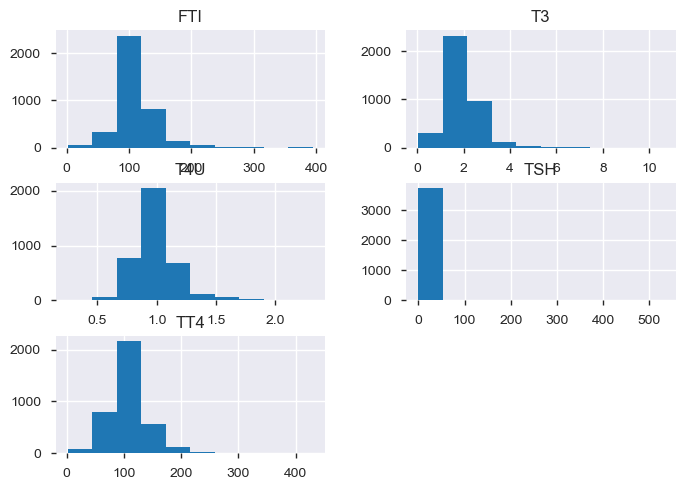

In [29]:
_ = df[['T3', 'T4U', 'FTI', 'TSH', 'TT4']].hist()

In [30]:
df['Class'].value_counts()

negative                   3481
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

из данных:

- FTI_measured сильно кореллирует с T4U_measured (ρ = 0.99712), уберём одну из анализа
- fti - normal
- class - 4 classes?
- TBG, TBG_measured - константы

FTI, T3, T4U, TSH, TT4, age


referral_source, sex - n classes

In [32]:
df.drop(columns=['TSH_measured', 'T3_measured', 'TT4_measured',
                'T4U_measured', 'FTI_measured', 'TBG_measured'],
        inplace=True)

In [31]:
numeric_columns = ['FTI', 'T3', 'T4U', 'TSH', 'TT4', 'age']


In [33]:
df = pd.concat([df,pd.get_dummies(df['referral_source'], prefix='referral_source')],axis=1)
df.drop(columns=['referral_source'], inplace=True)

In [40]:
df.replace('True', 1, inplace=True)
df.replace('False', 0, inplace=True)

## Построение моделей

In [120]:
import operator
def top_scores(coefs):
    coefs_dict = dict(zip(X.columns, coefs))
    sorted_dict = sorted(coefs_dict.items(), key=operator.itemgetter(1), reverse=True)
    sorted_dict[:5]

In [115]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics


In [116]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df["Class"])

In [117]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(multi_class='ovr'))
y = df["Class"]
X = df.drop(columns=["Class"])
scores = cross_val_score(pipe, X, y, cv=4)
print("cv score = " + str(np.mean(scores)))


cv score = 0.946717252844774


In [118]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(metrics.classification_report(y_pred, y_test))

                         precision    recall  f1-score   support

compensated_hypothyroid       0.09      0.62      0.15         8
               negative       1.00      0.95      0.97      1098
    primary_hypothyroid       0.75      0.81      0.78        26
  secondary_hypothyroid       0.00      0.00      0.00         0

            avg / total       0.99      0.94      0.96      1132



In [122]:
pipe.named_steps['logisticregression'].coef_

array([[-2.16042224e-02, -2.98494663e-01, -1.08972135e+00,
         1.16092019e-01, -1.83939120e-02,  2.39767659e-02,
        -4.09535660e-01, -4.43618950e-01, -2.06027877e-02,
         2.68629237e-01, -2.77046355e-02,  7.17204622e-02,
        -3.17441250e-01,  7.17687583e-02, -8.70097278e-02,
         1.42247568e-01,  2.88327090e-02, -8.73038650e-02,
        -3.47827172e-01,  2.62305720e-01, -1.75687206e-01,
        -2.70361624e-02, -3.25351281e-01,  4.76029928e-02,
         6.02432801e-02,  1.44833599e-01],
       [ 7.37524679e-02,  2.46129927e-01,  1.91384854e+00,
        -5.70092635e-02,  1.12943422e-02, -1.84448254e-02,
         3.15477708e-01,  2.64596341e+00,  7.17914932e-02,
        -1.73755999e-01,  1.14349690e-01, -6.85589282e-02,
         2.97427553e-01, -7.58599240e-02,  7.58436131e-02,
        -1.16963013e-01, -7.18175047e+00,  2.62750068e-01,
         6.92619882e-01, -3.45502257e-01,  1.93065947e-01,
        -7.57707906e-02,  2.27943116e-01, -5.08880677e-02,
        -4.81

In [121]:
top_scores(pipe.named_steps['logisticregression'].coef_)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [96]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced'))
y = df["Class"]
X = df.drop(columns=["Class"])
scores = cross_val_score(pipe, X, y, cv=4)
print("cv score = " + str(np.mean(scores)))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(metrics.classification_report(y_pred, y_test, ))

cv score = 0.9602334673168994
                         precision    recall  f1-score   support

compensated_hypothyroid       0.88      0.75      0.81        68
               negative       0.97      1.00      0.98      1013
    primary_hypothyroid       0.93      0.63      0.75        41
  secondary_hypothyroid       0.00      0.00      0.00        10

            avg / total       0.95      0.96      0.95      1132



In [97]:
from sklearn.model_selection import GridSearchCV
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
pipe = make_pipeline(StandardScaler(), LogisticRegression(multi_class='ovr', solver='lbfgs', class_weight='balanced'))
y = df["Class"]
X = df.drop(columns=["Class"])
                                                          
grid = GridSearchCV(estimator=pipe, param_grid=dict(logisticregression__C=Cs), cv=4, n_jobs=2, verbose=True)
_ = grid.fit(X_train, y_train) 

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=2)]: Done  28 out of  28 | elapsed:    2.2s finished


In [98]:
print(str(max(grid.cv_results_['mean_test_score'])))

0.9636363636363636


In [99]:
y_pred = grid.best_estimator_.predict(X_test)
print(metrics.classification_report(y_pred, y_test))

                         precision    recall  f1-score   support

compensated_hypothyroid       0.88      0.70      0.78        73
               negative       0.97      1.00      0.98      1019
    primary_hypothyroid       0.89      0.66      0.76        38
  secondary_hypothyroid       0.00      0.00      0.00         2

            avg / total       0.96      0.96      0.96      1132



Oversampling:

In [110]:
from imblearn import over_sampling
oversampler = over_sampling.RandomOverSampler()
X_sm, y_sm = oversampler.fit_sample(X, y)

In [113]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(multi_class='ovr', solver='lbfgs'))
scores = cross_val_score(pipe, X_sm, y_sm, cv=4)
print("cv score = " + str(np.mean(scores)))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(metrics.classification_report(y_pred, y_test, ))

cv score = 0.9199232616757063
                         precision    recall  f1-score   support

compensated_hypothyroid       0.12      0.88      0.21         8
               negative       1.00      0.96      0.98      1090
    primary_hypothyroid       0.89      0.74      0.81        34
  secondary_hypothyroid       0.00      0.00      0.00         0

            avg / total       0.99      0.95      0.97      1132

